# Feature Selection


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

# Load dataset
df = pd.read_csv('nhis_2022.csv')
initial_shape = df.shape

# Function to clean invalid codes
def clean_invalid(val):
    if pd.isna(val):
        return None
    if val in [7, 8, 9, 97, 98, 99, 996, 997, 998, 999]:
        return None
    return val

df = df.applymap(clean_invalid)

df = df[(df['AGE'] >= 50) & (df['AGE'] <= 60)]

df_clean = df.dropna()

if 'SEX' in df_clean.columns:
    df_clean['SEX'] = df_clean['SEX'].replace({1: 0, 2: 1})

X = df_clean.drop(columns='DIABETICEV')
y = df_clean['DIABETICEV']

# Keep only numeric columns for X
X_numeric = X.select_dtypes(include='number')

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Final cleaned datasets
X_cleaned = pd.DataFrame(X_scaled, columns=X_numeric.columns)
y_cleaned = y.reset_index(drop=True)

print(f"Initial shape: {initial_shape}")
print(f"Final shape after cleaning and filtering (AGE 50-60): {df_clean.shape}")


C:\Users\anime\AppData\Local\Temp\ipykernel_11656\3402791726.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(clean_invalid)


Initial shape: (35115, 48)
Final shape after cleaning and filtering (AGE 50-60): (705, 48)


C:\Users\anime\AppData\Local\Temp\ipykernel_11656\3402791726.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['SEX'] = df_clean['SEX'].replace({1: 0, 2: 1})


In [2]:
df_filtered = df_clean.drop(columns=['DIABETICEV', 'HEARTATTEV', 'STROKEV','SERIAL', 'PSU', 'SAMPWEIGHT','STRATA'])

df_heart = df_filtered[df_filtered['CHEARTDIEV'].isin([1, 2])].copy()
df_heart['HEART_FLAG'] = df_heart['CHEARTDIEV'].replace({1: 1, 2: 0})
df_filtered = df_clean.drop(columns=['CHEARTDIEV'])

# Prepare input matrix and target
X = df_heart.drop(columns=['CHEARTDIEV', 'HEART_FLAG'])
X = X.applymap(lambda x: np.nan if x in [996, 997, 998, 999] else x).dropna(axis=1)
y = df_heart['HEART_FLAG']

# Select numeric columns only
X_numeric = X.select_dtypes(include='number').dropna()

# Align y
X_numeric = X_numeric.loc[y.index]
selector_lr = SelectKBest(score_func=f_regression, k=5)
selector_lr.fit(X_numeric, y)
top_features_linear = X_numeric.columns[selector_lr.get_support()]
print("Top 5 features (Linear Regression):", top_features_linear.tolist())

Top 5 features (Linear Regression): ['AGE', 'HOURSWRK', 'POVERTY', 'CIGDAYMO', 'SPORDRMNO']


C:\Users\anime\AppData\Local\Temp\ipykernel_11656\4196096382.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: np.nan if x in [996, 997, 998, 999] else x).dropna(axis=1)


In [3]:
from sklearn.ensemble import RandomForestClassifier

# Fit Random Forest for feature importances
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_numeric, y)

# Top 5 features by importance
importances = pd.Series(rf.feature_importances_, index=X_numeric.columns)
top_features_rbf = importances.sort_values(ascending=False).head(5).index.tolist()
print("Top 5 features (Random Forest - RBF):", top_features_rbf)

Top 5 features (Random Forest - RBF): ['HEIGHT', 'WEIGHT', 'AGE', 'POVERTY', 'BMICALC']


# Gridsearch CV

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


In [5]:
param_grid_linear = {
    'C': [0.01, 0.1, 1]
}

svc_linear = SVC(kernel='linear')
grid_linear = GridSearchCV(svc_linear, param_grid_linear, cv=5, scoring='accuracy')
grid_linear.fit(X_cleaned[top_features_linear], y_cleaned)

print("Best parameters for Linear SVM:", grid_linear.best_params_)
print("Best CV accuracy for Linear SVM:", grid_linear.best_score_)


Best parameters for Linear SVM: {'C': 0.01}
Best CV accuracy for Linear SVM: 0.8595744680851064


In [6]:
param_grid_rbf = {
    'C': [0.1, 1,0.01],
    'gamma': [0.01, 0.1, 1]
}

svc_rbf = SVC(kernel='rbf')
grid_rbf = GridSearchCV(svc_rbf, param_grid_rbf, cv=5, scoring='accuracy')
grid_rbf.fit(X_cleaned[top_features_rbf], y_cleaned)

print("Best parameters for RBF SVM:", grid_rbf.best_params_)
print("Best CV accuracy for RBF SVM:", grid_rbf.best_score_)


Best parameters for RBF SVM: {'C': 1, 'gamma': 1}
Best CV accuracy for RBF SVM: 0.8624113475177305


In [7]:
param_grid_poly = {
    'C': [0.1, 1,0.01],
    'degree': [1, 2, 3],
    'gamma': ['scale', 'auto']
}

svc_poly = SVC(kernel='poly')
grid_poly = GridSearchCV(svc_poly, param_grid_poly, cv=5, scoring='accuracy')
grid_poly.fit(X_cleaned[top_features_rbf], y_cleaned)

print("Best parameters for Polynomial SVM:", grid_poly.best_params_)
print("Best CV accuracy for Polynomial SVM:", grid_poly.best_score_)


Best parameters for Polynomial SVM: {'C': 0.1, 'degree': 1, 'gamma': 'scale'}
Best CV accuracy for Polynomial SVM: 0.8595744680851064


# Linear SVM

Work hrs and age for heart issues

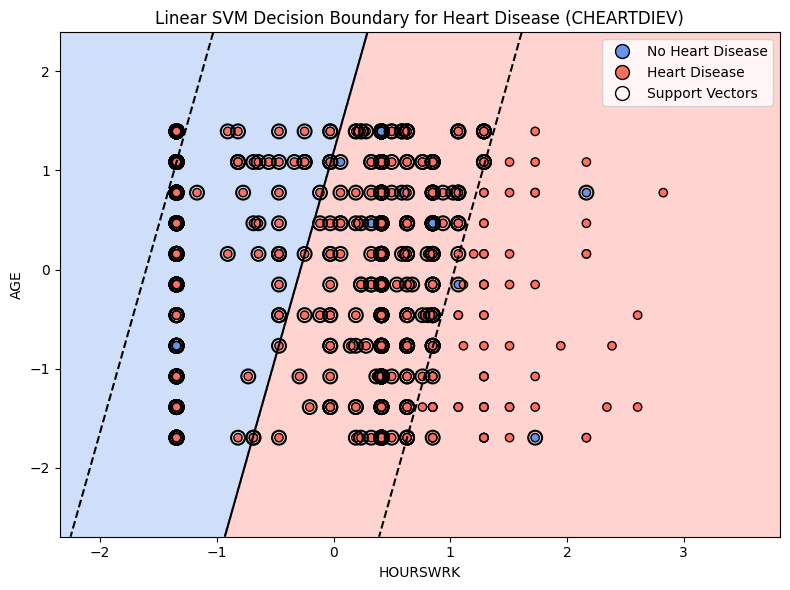

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC

# Features
feature1 = 'HOURSWRK'
feature2 = 'AGE'
X_vis = X_cleaned[[feature1, feature2]].values
y_vis = df_clean.reset_index(drop=True)['CHEARTDIEV'].replace({1: 1, 2: 0}).values

# SVM model
svc = SVC(kernel='linear', C=0.01, class_weight='balanced')
svc.fit(X_vis, y_vis)

# Mesh grid
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
Z_func = svc.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Color map (blue: No Disease, red: Heart Disease)
cmap = ListedColormap(['#6495ED', '#FF6F61'])  # blue, red

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)
plt.contour(xx, yy, Z_func, colors='k', levels=[-1, 0, 1], linestyles=['--', '-', '--'])

# Data points
scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_vis, cmap=cmap, edgecolors='k', label='Samples')

# Support vectors
plt.scatter(X_vis[svc.support_, 0], X_vis[svc.support_, 1],
            facecolors='none', edgecolors='black', linewidths=1.5,
            s=100, label='Support Vectors')

plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title('Linear SVM Decision Boundary for Heart Disease (CHEARTDIEV)')

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='No Heart Disease',
               markerfacecolor='#6495ED', markeredgecolor='k', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Heart Disease',
               markerfacecolor='#FF6F61', markeredgecolor='k', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Support Vectors',
               markerfacecolor='none', markeredgecolor='black', markersize=10, linewidth=1.5)
]
plt.legend(handles=handles, loc='upper right')
plt.tight_layout()
plt.show()


# Radial SVM

HEIGHT and WEIGHT for heart issues

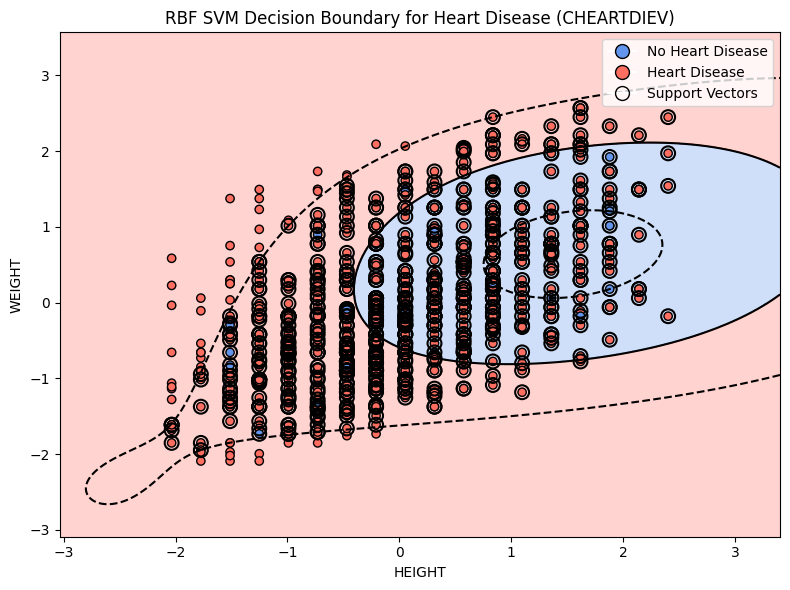

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC

# Features
feature1 = 'HEIGHT'
feature2 = 'WEIGHT'
X_vis = X_cleaned[[feature1, feature2]].values
y_vis = df_clean.reset_index(drop=True)['CHEARTDIEV'].replace({1: 1, 2: 0}).values

# Fit RBF SVM
svc = SVC(kernel='rbf', C=1, gamma=0.1, class_weight='balanced')
svc.fit(X_vis, y_vis)

# Create mesh grid
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
Z_func = svc.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Color map
cmap = ListedColormap(['#6495ED', '#FF6F61'])  # blue: No disease, red: Disease

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)
plt.contour(xx, yy, Z_func, colors='k', levels=[-1, 0, 1], linestyles=['--', '-', '--'])

# Data points
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_vis, cmap=cmap, edgecolors='k')

# Support vectors
plt.scatter(X_vis[svc.support_, 0], X_vis[svc.support_, 1],
            facecolors='none', edgecolors='black', linewidths=1.5,
            s=100, label='Support Vectors')

# Labels and legend
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title('RBF SVM Decision Boundary for Heart Disease (CHEARTDIEV)')

# Custom legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='No Heart Disease',
               markerfacecolor='#6495ED', markeredgecolor='k', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Heart Disease',
               markerfacecolor='#FF6F61', markeredgecolor='k', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Support Vectors',
               markerfacecolor='none', markeredgecolor='black', markersize=10, linewidth=1.5)
]
plt.legend(handles=handles, loc='upper right')
plt.tight_layout()
plt.show()


# Poly SVM

POVERTY and BMI for heart issues

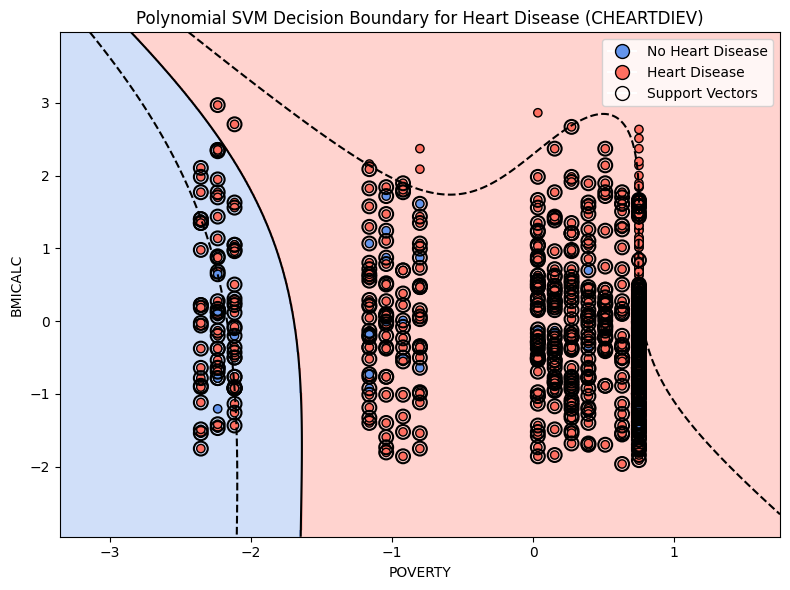

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC

# Features
feature1 = 'POVERTY'
feature2 = 'BMICALC'
X_vis = X_cleaned[[feature1, feature2]].values
y_vis = df_clean.reset_index(drop=True)['CHEARTDIEV'].replace({1: 1, 2: 0}).values

# Fit Polynomial SVM
svc = SVC(kernel='poly', degree=3, C=1, gamma='scale', class_weight='balanced')
svc.fit(X_vis, y_vis)

# Create mesh grid
x_min, x_max = X_vis[:, 0].min() - 1, X_vis[:, 0].max() + 1
y_min, y_max = X_vis[:, 1].min() - 1, X_vis[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
Z_func = svc.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Color map
cmap = ListedColormap(['#6495ED', '#FF6F61'])  # blue: No disease, red: Disease

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)
plt.contour(xx, yy, Z_func, colors='k', levels=[-1, 0, 1], linestyles=['--', '-', '--'])

# Scatter data points
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=y_vis, cmap=cmap, edgecolors='k')

# Support vectors
plt.scatter(X_vis[svc.support_, 0], X_vis[svc.support_, 1],
            facecolors='none', edgecolors='black', linewidths=1.5,
            s=100, label='Support Vectors')

# Labels and legend
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title('Polynomial SVM Decision Boundary for Heart Disease (CHEARTDIEV)')

# Custom legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='No Heart Disease',
               markerfacecolor='#6495ED', markeredgecolor='k', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Heart Disease',
               markerfacecolor='#FF6F61', markeredgecolor='k', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Support Vectors',
               markerfacecolor='none', markeredgecolor='black', markersize=10, linewidth=1.5)
]
plt.legend(handles=handles, loc='upper right')
plt.tight_layout()
plt.show()


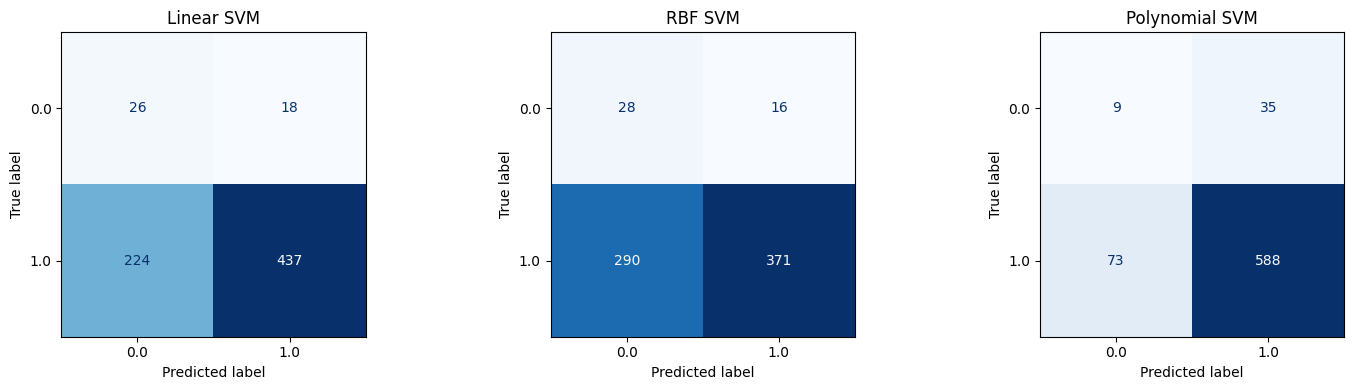

,Model,Accuracy,Precision,Recall,F1 Score
0,Linear SVM,0.656738,0.960440,0.661120,0.783154
1,RBF SVM,0.565957,0.958656,0.561271,0.708015
2,Polynomial SVM,0.846809,0.943820,0.889561,0.915888


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pandas as pd

y_true = df_clean.reset_index(drop=True)['CHEARTDIEV'].replace({1: 1, 2: 0}).values

features_linear = ['HOURSWRK', 'AGE']
X_linear = X_cleaned[features_linear].values
svm_linear = SVC(kernel='linear', C=0.01, class_weight='balanced')
svm_linear.fit(X_linear, y_true)
y_pred_linear = svm_linear.predict(X_linear)

features_rbf = ['HEIGHT', 'WEIGHT']
X_rbf = X_cleaned[features_rbf].values
svm_rbf = SVC(kernel='rbf', C=1, gamma=0.1, class_weight='balanced')
svm_rbf.fit(X_rbf, y_true)
y_pred_rbf = svm_rbf.predict(X_rbf)

features_poly = ['POVERTY', 'BMICALC']
X_poly = X_cleaned[features_poly].values
svm_poly = SVC(kernel='poly', degree=3, C=1, gamma='scale', class_weight='balanced')
svm_poly.fit(X_poly, y_true)
y_pred_poly = svm_poly.predict(X_poly)

# ---- Evaluation Function ----
def evaluate_model(name, y_true, y_pred):
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'Confusion Matrix': confusion_matrix(y_true, y_pred).tolist()
    }

results = [
    evaluate_model("Linear SVM", y_true, y_pred_linear),
    evaluate_model("RBF SVM", y_true, y_pred_rbf),
    evaluate_model("Polynomial SVM", y_true, y_pred_poly)
]

df_results = pd.DataFrame(results).drop(columns='Confusion Matrix')
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i, (model, y_pred) in enumerate(zip(
    ["Linear", "RBF", "Polynomial"],
    [y_pred_linear, y_pred_rbf, y_pred_poly]
)):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=axs[i], cmap='Blues', colorbar=False)
    axs[i].set_title(f"{model} SVM")
plt.tight_layout()
plt.show()

df_results


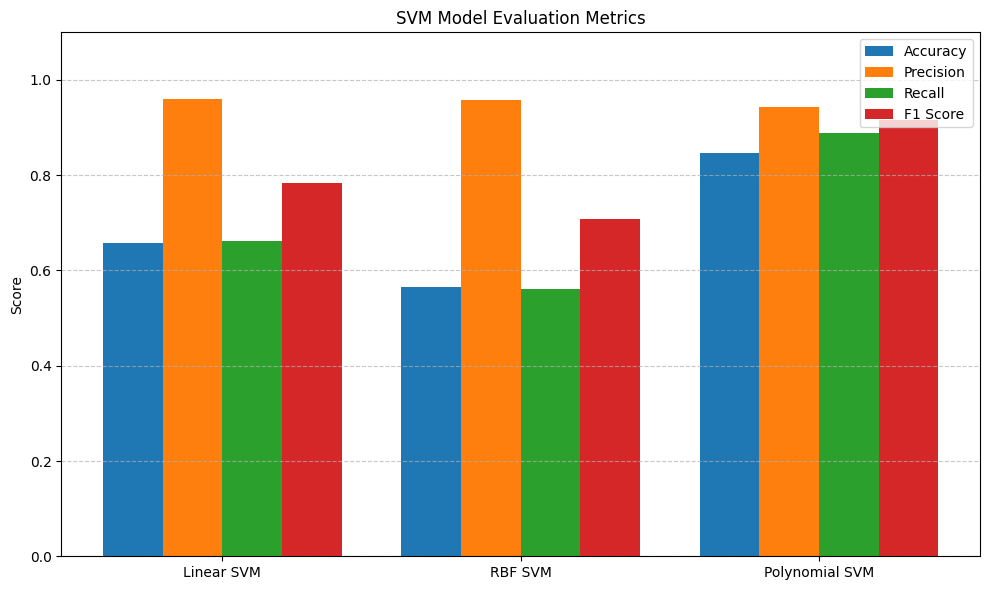

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
data = {
    "Model": ["Linear SVM", "RBF SVM", "Polynomial SVM"],
    "Accuracy": [0.656738, 0.565957, 0.846809],
    "Precision": [0.960440, 0.958656, 0.943820],
    "Recall": [0.661120, 0.561271, 0.889561],
    "F1 Score": [0.783154, 0.708015, 0.915888]
}
df = pd.DataFrame(data)

# Plot
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
x = range(len(df["Model"]))
bar_width = 0.2

plt.figure(figsize=(10, 6))
for i, metric in enumerate(metrics):
    plt.bar([p + i * bar_width for p in x], df[metric], width=bar_width, label=metric)

plt.xticks([p + 1.5 * bar_width for p in x], df["Model"])
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.title("SVM Model Evaluation Metrics")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


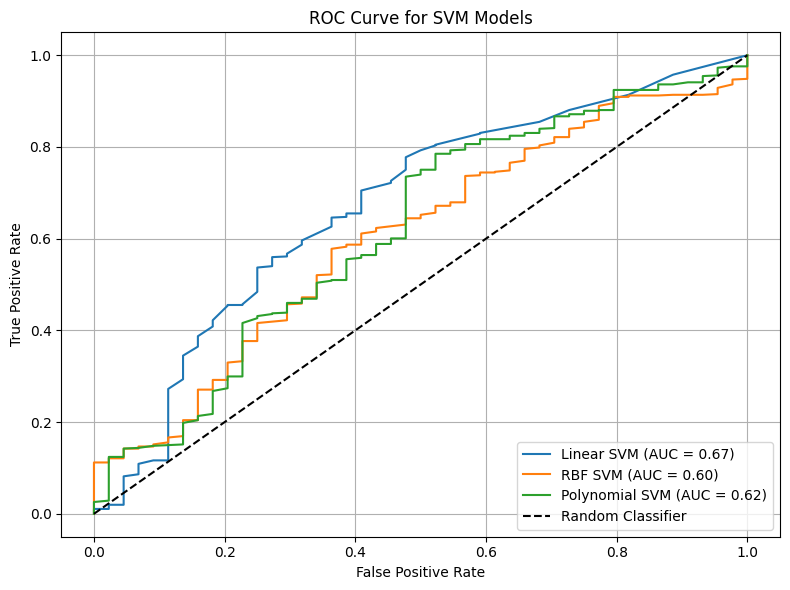

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_score_linear = svc_linear.predict_proba(X_linear)[:, 1]
y_score_rbf = svc_rbf.predict_proba(X_rbf)[:, 1]
y_score_poly = svc_poly.predict_proba(X_poly)[:, 1]

# Compute ROC and AUC
fpr_lin, tpr_lin, _ = roc_curve(y_true, y_score_linear)
fpr_rbf, tpr_rbf, _ = roc_curve(y_true, y_score_rbf)
fpr_poly, tpr_poly, _ = roc_curve(y_true, y_score_poly)

auc_lin = roc_auc_score(y_true, y_score_linear)
auc_rbf = roc_auc_score(y_true, y_score_rbf)
auc_poly = roc_auc_score(y_true, y_score_poly)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lin, tpr_lin, label=f'Linear SVM (AUC = {auc_lin:.2f})')
plt.plot(fpr_rbf, tpr_rbf, label=f'RBF SVM (AUC = {auc_rbf:.2f})')
plt.plot(fpr_poly, tpr_poly, label=f'Polynomial SVM (AUC = {auc_poly:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
